# Window function and amplitude correction

In [1]:
from radiocalibrationtoolkit import *
from scipy.signal import butter, lfilter
from scipy.signal import blackmanharris, boxcar, hann

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Examine effects on a single trace

In [3]:
N = 2048   # samples
fs_Hz = 250e6 # sampling frequency
signal_freq_Hz = 55.5e6 # signal
win = blackmanharris(N) # window function type

In [4]:
tx = np.arange(N) / fs_Hz
def make_simple_time_trace(signal_amplitude=0.7, signal_frequency=55.5e+6, noise_amplitude=1, N=2048, apply_filter=True):
    time_trace = signal_amplitude * np.sin(2*np.pi*signal_frequency*tx) + noise_amplitude * np.random.normal(size=N)
    b, a = butter(5, [30e6, 80e6], fs=250e6, btype='band')
    if apply_filter:
        time_trace = lfilter(b, a, time_trace)
    return np.round(time_trace * N) / N

Text(0, 0.5, 'amplitude [ADC]')

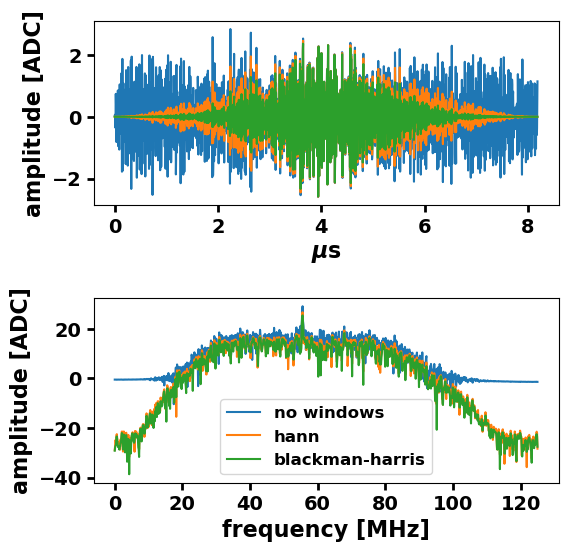

In [5]:
tt = make_simple_time_trace(signal_amplitude=1)
fx = np.fft.rfftfreq(N, 1/fs_Hz)*1e-6

fig, ax = plt.subplots(2,1, figsize=(6,6))
labels = ['no windows', 'hann', 'blackman-harris']
for i, w in enumerate([1, hann(N), blackmanharris(N)]):
    ax[0].plot(tx*1e+6, tt*w)
    ax[1].plot(fx, 10*np.log10(np.abs(np.fft.rfft(tt*w))), label=labels[i])

fig.subplots_adjust(hspace=0.5)
ax[1].legend()

ax[0].set_xlabel("$\mu$s")
ax[1].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")


In [6]:
# generate time trace
time_trace = make_simple_time_trace()

# calculate two sided spectrum
spectrum = np.abs(fft(time_trace))
# calculate one sided spectrum (not corrected for the one side)
rspectrum = np.abs(np.fft.rfft(time_trace))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)

# calculate amplitude window function correction
Aw = N/np.sum(win) /np.sqrt(2)

# calculate two sided spectrum using a window function (not corrected for the one side)
spectrum_w = np.abs(fft(time_trace*win))
# calculate one sided spectrum using a window function (not corrected for the one side)
rspectrum_w = np.abs(np.fft.rfft(time_trace*win))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)
r2spectrum_w = correct_energy_of_one_sided_spectrum(rspectrum_w)

# define X-axis values
fx = np.fft.rfftfreq(N, 1/fs_Hz)/1e+6

In [7]:
# calculate energy from time trace, one and two sided spectrum with and without window
# when the window is used, the amplitudes are corrected
print(
    f"Energy calculated from:\n"
    f"time trace = {get_energy_from_time_trace(time_trace):.2f},\n"
    f"two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum):.2f},\n"
    f"one sided spectrum = {get_energy_from_one_sided_spectrum(rspectrum):.2f},\n"
    f"windowed two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum_w):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum):.2f},\n"
    f"windowed two sided spectrum corrected by window function loss = {get_energy_from_two_sided_spectrum(spectrum_w * Aw):.2f},\n"
    f"windowed one sided spectrum corrected by window function loss = {get_energy_from_one_sided_spectrum(rspectrum_w * Aw):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum and for window function loss = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum_w*Aw):.2f},\n"
)

Energy calculated from:
time trace = 1331.51,
two sided spectrum = 1331.51,
one sided spectrum = 1331.51,
windowed two sided spectrum = 307.86,
one sided spectrum corrected for being the one sided spectrum = 1331.51,
windowed two sided spectrum corrected by window function loss = 1197.21,
windowed one sided spectrum corrected by window function loss = 1197.21,
one sided spectrum corrected for being the one sided spectrum and for window function loss = 1197.21,



### Trace with a broad band pulse

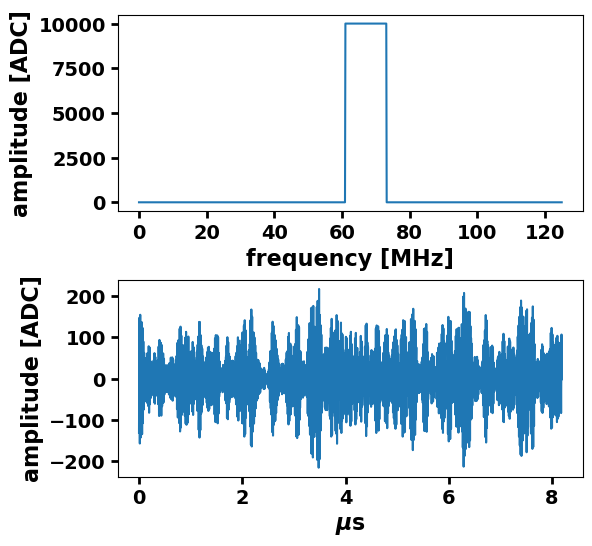

In [8]:
# create a broad band noise trace
bb_spec=np.zeros(1025)
bb_spec[500:600] = 10000


bb_tt = np.real(ifft(one_sided_2_complex_two_sided(bb_spec)))

fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")
ax[1].set_xlabel("$\mu$s")

ax[0].plot(fx, bb_spec)
ax[1].plot(tx*1e+6, bb_tt)

fig.subplots_adjust(hspace=0.35)

In [9]:
# add broad band pulse to the time trace
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]

rspectrum_e = np.abs(np.fft.rfft(time_trace_e))
rspectrum_w_e = np.abs(np.fft.rfft(time_trace_e*win))


In [10]:
def show_plots(time_trace, show_window_func=True):
    rspectrum = np.abs(np.fft.rfft(time_trace))
    rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
    Aw = N / np.sum(win) / np.sqrt(2)

    e_tt = get_energy_from_time_trace(time_trace)
    e_spec = get_energy_from_one_sided_spectrum(rspectrum)
    e_spec_w = get_energy_from_one_sided_spectrum(rspectrum_w * Aw)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    mu = 1e6
    ax[0].plot(
        tx * mu, time_trace, label="no window: E={:.1f} a.u.".format(e_tt), alpha=0.7
    )
    ax[0].plot(tx * mu, time_trace * win, label="windowed", alpha=0.7)
    
    if show_window_func:
        ax[0].plot(tx * mu, win * 100, label="window func. x100", alpha=1)

    ax[1].plot(
        fx , rspectrum, label="no window:         E={:.1f} a.u.".format(e_spec), alpha=0.7
    )

    ax[1].plot(
        fx ,
        rspectrum_w * Aw,
        label="windowed & A$_w$: E={:.1f} a.u.".format(e_spec_w),
        alpha=0.7,
    )

    display(
        get_energy_from_time_trace(time_trace),
        get_energy_from_one_sided_spectrum(rspectrum),
        get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
    )

    ax[0].set_xlabel("$\mu$s")
    ax[1].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("amplitude [ADC]")
    ax[1].set_ylabel("amplitude [ADC]")

    ax[0].legend()
    ax[1].legend()
    
    fig.subplots_adjust(hspace=0.3)

1331.508845090866

1331.508845090866

1197.2052109672604

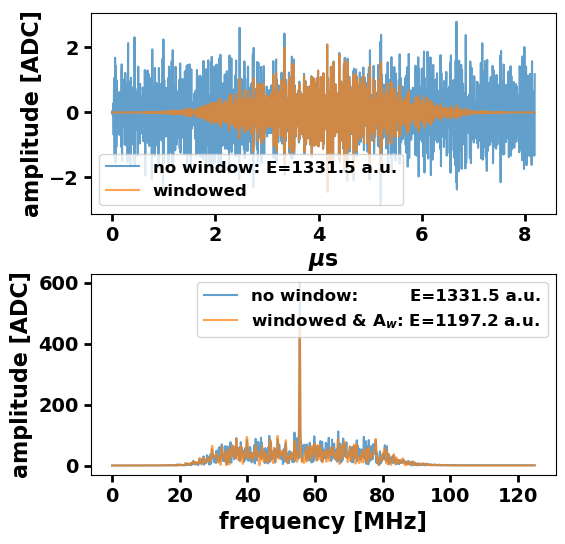

In [11]:
# trace without the broad band pulse
show_plots(time_trace, show_window_func=False)

283401.7596630002

283401.75966300024

1095628.6692379967

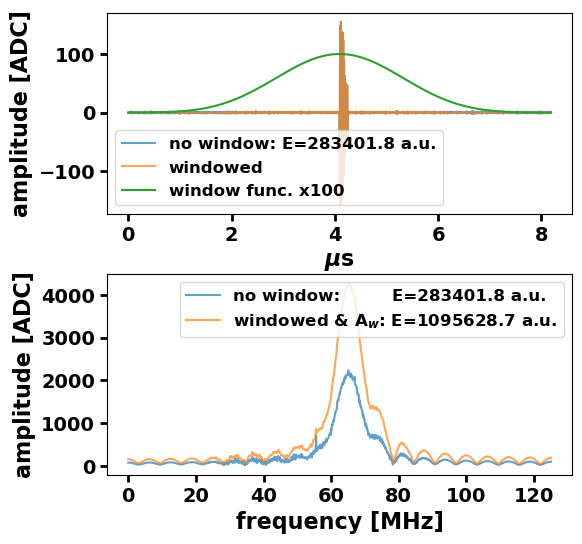

In [12]:
# trace with the broad band pulse
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]
show_plots(time_trace_e)

283401.75966300024

283401.75966300024

53417.808481004584

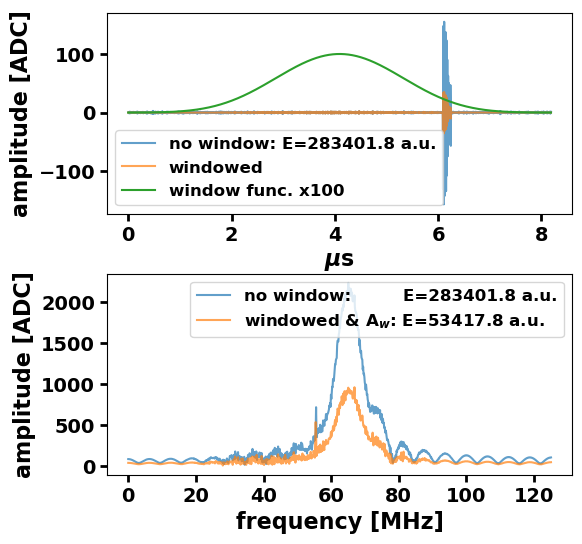

In [13]:
# rolled trace to shift the broad band pulse
show_plots(np.roll(time_trace_e, 500))

The learning here is that a amplitudes of a trace with broad band pulse cannot be safely corrected
after the window function because the window function is symmetric and the broad band pulse appearing 
in random parts of the trace will be each time differently supressed by the window function.

Note that the energy of the trace is after the rolling of the trace still the same when no window is used.

## Distributions of the energy ratios of not windowed spectra and windowed spectra with amplitude correction

In [14]:
def get_averaged_spectra_and_diffs(arr):
    diffs = np.array([])
    n, N = arr.shape
    avr_rspectrum = 0
    avr_rspectrum_w = 0
    win = blackmanharris(N)
    Aw = N / np.sum(win) / np.sqrt(2)
    for i in range(n):
        time_trace = arr[i, :]
        rspectrum = np.abs(np.fft.rfft(time_trace))
        rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
        diffs = np.append(
            diffs,
            get_energy_from_time_trace(time_trace)
            / get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
        )
        avr_rspectrum += rspectrum
        avr_rspectrum_w += rspectrum_w

    avr_rspectrum /= n
    avr_rspectrum_w /= n
    return avr_rspectrum, avr_rspectrum_w, diffs


def show_results(
    avr_rspectrum,
    avr_rspectrum_w,
    diffs,
    histo_edge=2,
    N=2048,
    bins=None,
    xax_min=None,
    xax_max=None,
    xlim= [None, None]
):
    fig, ax = plt.subplots()
    fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

    if bins == None:
        bins = linspace_with_middle_value(
            np.mean(diffs), histo_edge * np.std(diffs), 20
        )
    ax.hist(diffs, bins=bins)
    # Calculate mean and standard deviation
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    print(mean_diff)
    print(std_diff)

    # Add text box with mean and standard deviation
    text_box = f"$\mu$: {mean_diff:.2f}\n$\sigma$: {std_diff:.2f}"
    ax.text(
        0.95,
        0.95,
        text_box,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    ax.set_xlim(xax_min, xax_max)
    ax.set_xlabel(
        r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}}$"
    )
    ax.set_ylabel("entries")

    fig, ax = plt.subplots()

    ax.plot(fx, voltageAmp2dB(avr_rspectrum), alpha=0.7, label="no window")
    ax.plot(fx, voltageAmp2dB(avr_rspectrum_w), alpha=0.7, label="with window")
    ax.plot(
        fx,
        voltageAmp2dB(avr_rspectrum_w * Aw),
        alpha=0.7,
        label="with window " + "\n" + "and corrected",
    )
    
    
    # ax.axes.axvspan(30,80, color='b', alpha=0.1)
    ax.set_xlim(*xlim)
    autoscale_y(ax)     
    
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("dB")
    ax.legend()

### Simple traces

In [15]:
# create a set of 1000 time traces
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_traces = np.vstack((time_traces, make_simple_time_trace()))

In [16]:
# calculate energy ratios of unwindowed spectra and windowed with amplitude correction
# and average spectra
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)
diffs1 = diffs
label4final_histo = ['simple traces']

0.9994624449949288
0.06096294287115251


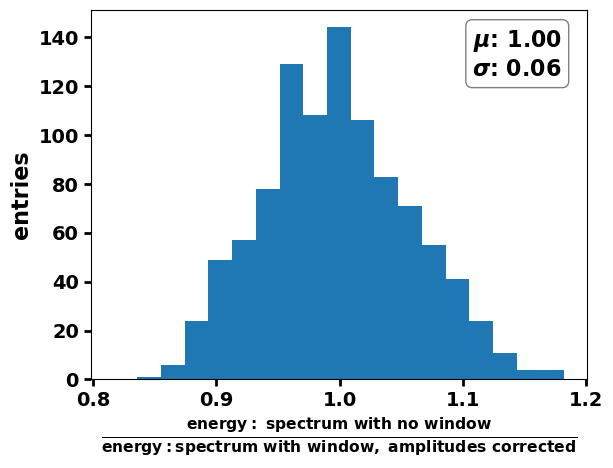

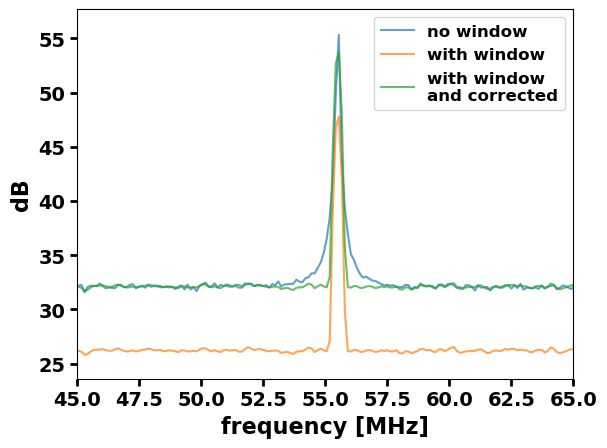

In [17]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, xlim=[45, 65])

In [18]:
# create a set of 1000 time traces with bb pulses
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_trace = make_simple_time_trace()
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    time_traces = np.vstack((time_traces, time_trace))

In [19]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)

62.55018557812781
86.75171679725935


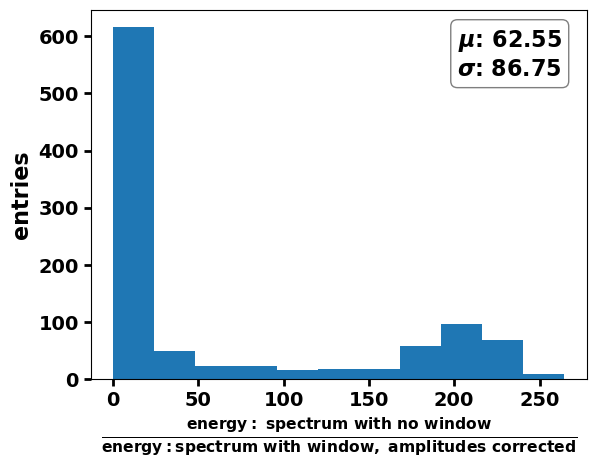

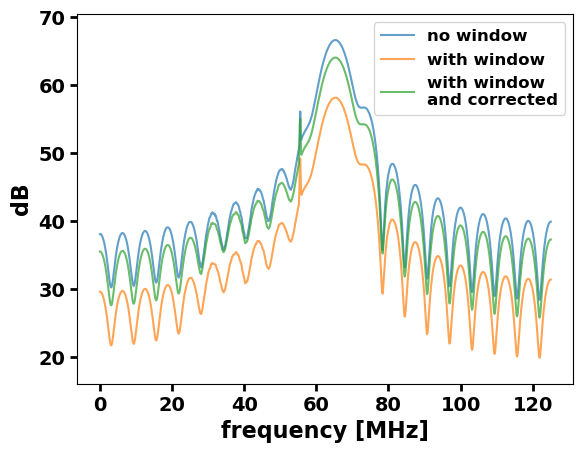

In [20]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, bins='auto')
# ,xax_min=-10, xax_max=80)

### Mock traces

In [21]:
# read HW response
hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={"fill_value": "extrapolate"})

hw_reponse_1 = hw_dict["RResponse"]["LNA"]
hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]


# merge all hw responses to one function
def hw_response_func(x):
    return dB2PowerAmp(
        hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
    )


# impedance function
impedance_func = hw_dict["IImpedance"][
    "antenna_EW"
]

# read sidereal voltage square spectral density
sidereal_voltage2_density_DF = pd.read_csv(
    "./voltage2_density/voltage2_density_Salla_EW_GSM16.csv",
    index_col=0,
)
sidereal_voltage2_density_DF.columns = sidereal_voltage2_density_DF.columns.astype(
    float
)

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7f135e352400>


In [22]:
mock_trace_generator = Mock_trace_generator(
    sidereal_voltage2_density_DF=sidereal_voltage2_density_DF,
    hw_response_func=hw_response_func,
    impedance_func=impedance_func,
    voltage2ADC=2048,
    time_trace_size=2048,
    sampling_frequency_MHz=250,
)
freq_MHz_bins = mock_trace_generator.get_frequency_bins()

In [23]:
piko = 1e-12
additional_noise = 5e-4*piko
debug_spectra_dict = mock_trace_generator.generate_mock_trace(
    1,
    lst=15,
    temp_celsius=30,
    nbi={"67.2": 1},
    nbi_err=0.2,
    return_debug_dict=True,
    additional_noise=additional_noise,
)[0]

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.90it/s]

In [24]:
number_of_traces = 1000
mock_traces_DF = mock_trace_generator.generate_mock_trace(
    number_of_traces,
    temp_celsius=[-10,30],
    additional_noise=additional_noise,
    nbi={"67.25": 1},
    nbi_err=0.3,
)

  0%|                                                                                                                                       | 0/1000 [00:00<?, ?it/s]

  0%|▌                                                                                                                              | 4/1000 [00:00<00:34, 28.96it/s]

  1%|▉                                                                                                                              | 7/1000 [00:00<00:33, 29.31it/s]

  1%|█▍                                                                                                                            | 11/1000 [00:00<00:32, 30.29it/s]

  2%|█▉                                                                                                                            | 15/1000 [00:00<00:31, 30.79it/s]

  2%|██▍                                                                                                                           | 19/1000 [00:00<00:31, 30.94it/s]

  2%|██▉                                                                                                                           | 23/1000 [00:00<00:31, 31.08it/s]

  3%|███▍                                                                                                                          | 27/1000 [00:00<00:31, 31.23it/s]

  3%|███▉                                                                                                                          | 31/1000 [00:01<00:31, 31.20it/s]

  4%|████▍                                                                                                                         | 35/1000 [00:01<00:30, 31.17it/s]

  4%|████▉                                                                                                                         | 39/1000 [00:01<00:30, 31.19it/s]

  4%|█████▍                                                                                                                        | 43/1000 [00:01<00:30, 31.38it/s]

  5%|█████▉                                                                                                                        | 47/1000 [00:01<00:30, 31.37it/s]

  5%|██████▍                                                                                                                       | 51/1000 [00:01<00:30, 31.39it/s]

  6%|██████▉                                                                                                                       | 55/1000 [00:01<00:30, 30.89it/s]

  6%|███████▍                                                                                                                      | 59/1000 [00:01<00:30, 31.27it/s]

  6%|███████▉                                                                                                                      | 63/1000 [00:02<00:29, 31.62it/s]

  7%|████████▍                                                                                                                     | 67/1000 [00:02<00:29, 31.84it/s]

  7%|████████▉                                                                                                                     | 71/1000 [00:02<00:33, 27.84it/s]

  8%|█████████▍                                                                                                                    | 75/1000 [00:02<00:31, 28.99it/s]

  8%|█████████▉                                                                                                                    | 79/1000 [00:02<00:30, 29.84it/s]

  8%|██████████▍                                                                                                                   | 83/1000 [00:02<00:30, 30.44it/s]

  9%|██████████▉                                                                                                                   | 87/1000 [00:02<00:29, 30.89it/s]

  9%|███████████▍                                                                                                                  | 91/1000 [00:02<00:29, 31.18it/s]

 10%|███████████▉                                                                                                                  | 95/1000 [00:03<00:28, 31.32it/s]

 10%|████████████▍                                                                                                                 | 99/1000 [00:03<00:28, 31.50it/s]

 10%|████████████▉                                                                                                                | 103/1000 [00:03<00:28, 31.65it/s]

 11%|█████████████▍                                                                                                               | 107/1000 [00:03<00:28, 31.63it/s]

 11%|█████████████▉                                                                                                               | 111/1000 [00:03<00:28, 31.45it/s]

 12%|██████████████▍                                                                                                              | 115/1000 [00:03<00:27, 31.63it/s]

 12%|██████████████▉                                                                                                              | 119/1000 [00:03<00:27, 31.72it/s]

 12%|███████████████▍                                                                                                             | 123/1000 [00:03<00:27, 31.83it/s]

 13%|███████████████▉                                                                                                             | 127/1000 [00:04<00:27, 31.94it/s]

 13%|████████████████▍                                                                                                            | 131/1000 [00:04<00:26, 32.97it/s]

 14%|████████████████▉                                                                                                            | 135/1000 [00:04<00:25, 33.79it/s]

 14%|█████████████████▍                                                                                                           | 139/1000 [00:04<00:25, 34.39it/s]

 14%|█████████████████▉                                                                                                           | 143/1000 [00:04<00:24, 34.73it/s]

 15%|██████████████████▍                                                                                                          | 147/1000 [00:04<00:24, 35.01it/s]

 15%|██████████████████▉                                                                                                          | 151/1000 [00:04<00:24, 35.23it/s]

 16%|███████████████████▍                                                                                                         | 155/1000 [00:04<00:23, 35.38it/s]

 16%|███████████████████▉                                                                                                         | 159/1000 [00:04<00:23, 35.43it/s]

 16%|████████████████████▍                                                                                                        | 163/1000 [00:05<00:23, 35.45it/s]

 17%|████████████████████▉                                                                                                        | 167/1000 [00:05<00:23, 35.44it/s]

 17%|█████████████████████▍                                                                                                       | 171/1000 [00:05<00:23, 35.38it/s]

 18%|█████████████████████▉                                                                                                       | 175/1000 [00:05<00:23, 35.39it/s]

 18%|██████████████████████▍                                                                                                      | 179/1000 [00:05<00:23, 35.38it/s]

 18%|██████████████████████▉                                                                                                      | 183/1000 [00:05<00:23, 35.37it/s]

 19%|███████████████████████▍                                                                                                     | 187/1000 [00:05<00:22, 35.41it/s]

 19%|███████████████████████▉                                                                                                     | 191/1000 [00:05<00:22, 35.40it/s]

 20%|████████████████████████▍                                                                                                    | 195/1000 [00:06<00:22, 35.40it/s]

 20%|████████████████████████▉                                                                                                    | 199/1000 [00:06<00:22, 35.30it/s]

 20%|█████████████████████████▍                                                                                                   | 203/1000 [00:06<00:22, 35.27it/s]

 21%|█████████████████████████▉                                                                                                   | 207/1000 [00:06<00:22, 35.34it/s]

 21%|██████████████████████████▍                                                                                                  | 211/1000 [00:06<00:22, 34.98it/s]

 22%|██████████████████████████▉                                                                                                  | 215/1000 [00:06<00:22, 35.15it/s]

 22%|███████████████████████████▍                                                                                                 | 219/1000 [00:06<00:22, 35.23it/s]

 22%|███████████████████████████▉                                                                                                 | 223/1000 [00:06<00:22, 35.25it/s]

 23%|████████████████████████████▍                                                                                                | 227/1000 [00:06<00:21, 35.30it/s]

 23%|████████████████████████████▉                                                                                                | 231/1000 [00:07<00:21, 35.32it/s]

 24%|█████████████████████████████▍                                                                                               | 235/1000 [00:07<00:22, 33.70it/s]

 24%|█████████████████████████████▉                                                                                               | 239/1000 [00:07<00:22, 34.33it/s]

 24%|██████████████████████████████▍                                                                                              | 243/1000 [00:07<00:21, 34.75it/s]

 25%|██████████████████████████████▉                                                                                              | 247/1000 [00:07<00:21, 35.10it/s]

 25%|███████████████████████████████▍                                                                                             | 251/1000 [00:07<00:21, 35.30it/s]

 26%|███████████████████████████████▉                                                                                             | 255/1000 [00:07<00:21, 35.37it/s]

 26%|████████████████████████████████▍                                                                                            | 259/1000 [00:07<00:20, 35.47it/s]

 26%|████████████████████████████████▉                                                                                            | 263/1000 [00:07<00:20, 35.48it/s]

 27%|█████████████████████████████████▍                                                                                           | 267/1000 [00:08<00:20, 35.51it/s]

 27%|█████████████████████████████████▉                                                                                           | 271/1000 [00:08<00:20, 35.46it/s]

 28%|██████████████████████████████████▍                                                                                          | 275/1000 [00:08<00:20, 35.53it/s]

 28%|██████████████████████████████████▉                                                                                          | 279/1000 [00:08<00:20, 35.54it/s]

 28%|███████████████████████████████████▍                                                                                         | 283/1000 [00:08<00:20, 35.51it/s]

 29%|███████████████████████████████████▉                                                                                         | 287/1000 [00:08<00:20, 35.52it/s]

 29%|████████████████████████████████████▍                                                                                        | 291/1000 [00:08<00:19, 35.49it/s]

 30%|████████████████████████████████████▉                                                                                        | 295/1000 [00:08<00:19, 35.48it/s]

 30%|█████████████████████████████████████▍                                                                                       | 299/1000 [00:08<00:19, 35.43it/s]

 30%|█████████████████████████████████████▉                                                                                       | 303/1000 [00:09<00:19, 35.41it/s]

 31%|██████████████████████████████████████▍                                                                                      | 307/1000 [00:09<00:19, 35.26it/s]

 31%|██████████████████████████████████████▉                                                                                      | 311/1000 [00:09<00:19, 35.34it/s]

 32%|███████████████████████████████████████▍                                                                                     | 315/1000 [00:09<00:19, 35.36it/s]

 32%|███████████████████████████████████████▉                                                                                     | 319/1000 [00:09<00:19, 35.32it/s]

 32%|████████████████████████████████████████▍                                                                                    | 323/1000 [00:09<00:19, 35.30it/s]

 33%|████████████████████████████████████████▉                                                                                    | 327/1000 [00:09<00:19, 35.27it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 331/1000 [00:09<00:18, 35.31it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 335/1000 [00:09<00:18, 35.31it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 339/1000 [00:10<00:18, 35.31it/s]

 34%|██████████████████████████████████████████▉                                                                                  | 343/1000 [00:10<00:18, 35.34it/s]

 35%|███████████████████████████████████████████▍                                                                                 | 347/1000 [00:10<00:18, 35.37it/s]

 35%|███████████████████████████████████████████▉                                                                                 | 351/1000 [00:10<00:18, 35.36it/s]

 36%|████████████████████████████████████████████▍                                                                                | 355/1000 [00:10<00:18, 35.32it/s]

 36%|████████████████████████████████████████████▉                                                                                | 359/1000 [00:10<00:18, 35.32it/s]

 36%|█████████████████████████████████████████████▍                                                                               | 363/1000 [00:10<00:18, 35.36it/s]

 37%|█████████████████████████████████████████████▉                                                                               | 367/1000 [00:10<00:17, 35.37it/s]

 37%|██████████████████████████████████████████████▍                                                                              | 371/1000 [00:10<00:17, 35.37it/s]

 38%|██████████████████████████████████████████████▉                                                                              | 375/1000 [00:11<00:17, 35.39it/s]

 38%|███████████████████████████████████████████████▍                                                                             | 379/1000 [00:11<00:17, 35.24it/s]

 38%|███████████████████████████████████████████████▉                                                                             | 383/1000 [00:11<00:17, 35.22it/s]

 39%|████████████████████████████████████████████████▍                                                                            | 387/1000 [00:11<00:17, 35.23it/s]

 39%|████████████████████████████████████████████████▉                                                                            | 391/1000 [00:11<00:17, 35.23it/s]

 40%|█████████████████████████████████████████████████▍                                                                           | 395/1000 [00:11<00:17, 35.17it/s]

 40%|█████████████████████████████████████████████████▉                                                                           | 399/1000 [00:11<00:17, 35.20it/s]

 40%|██████████████████████████████████████████████████▍                                                                          | 403/1000 [00:11<00:16, 35.20it/s]

 41%|██████████████████████████████████████████████████▉                                                                          | 407/1000 [00:12<00:16, 35.18it/s]

 41%|███████████████████████████████████████████████████▍                                                                         | 411/1000 [00:12<00:16, 35.07it/s]

 42%|███████████████████████████████████████████████████▉                                                                         | 415/1000 [00:12<00:16, 35.08it/s]

 42%|████████████████████████████████████████████████████▍                                                                        | 419/1000 [00:12<00:16, 35.11it/s]

 42%|████████████████████████████████████████████████████▉                                                                        | 423/1000 [00:12<00:16, 35.13it/s]

 43%|█████████████████████████████████████████████████████▍                                                                       | 427/1000 [00:12<00:16, 35.13it/s]

 43%|█████████████████████████████████████████████████████▉                                                                       | 431/1000 [00:12<00:16, 35.09it/s]

 44%|██████████████████████████████████████████████████████▍                                                                      | 435/1000 [00:12<00:16, 35.10it/s]

 44%|██████████████████████████████████████████████████████▉                                                                      | 439/1000 [00:12<00:15, 35.10it/s]

 44%|███████████████████████████████████████████████████████▍                                                                     | 443/1000 [00:13<00:15, 35.05it/s]

 45%|███████████████████████████████████████████████████████▉                                                                     | 447/1000 [00:13<00:15, 35.04it/s]

 45%|████████████████████████████████████████████████████████▍                                                                    | 451/1000 [00:13<00:15, 35.09it/s]

 46%|████████████████████████████████████████████████████████▉                                                                    | 455/1000 [00:13<00:15, 35.16it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                   | 459/1000 [00:13<00:15, 35.12it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                   | 463/1000 [00:13<00:15, 35.01it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                  | 467/1000 [00:13<00:15, 35.04it/s]

 47%|██████████████████████████████████████████████████████████▉                                                                  | 471/1000 [00:13<00:15, 35.09it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                 | 475/1000 [00:13<00:14, 35.03it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                 | 479/1000 [00:14<00:17, 30.60it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                | 483/1000 [00:14<00:16, 31.52it/s]

 49%|████████████████████████████████████████████████████████████▉                                                                | 487/1000 [00:14<00:15, 32.46it/s]

 49%|█████████████████████████████████████████████████████████████▍                                                               | 491/1000 [00:14<00:15, 33.14it/s]

 50%|█████████████████████████████████████████████████████████████▉                                                               | 495/1000 [00:14<00:15, 33.57it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                              | 499/1000 [00:14<00:14, 33.89it/s]

 50%|██████████████████████████████████████████████████████████████▉                                                              | 503/1000 [00:14<00:14, 34.18it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                             | 507/1000 [00:14<00:14, 34.43it/s]

 51%|███████████████████████████████████████████████████████████████▉                                                             | 511/1000 [00:15<00:14, 34.59it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                            | 515/1000 [00:15<00:13, 34.66it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                            | 519/1000 [00:15<00:13, 34.73it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 523/1000 [00:15<00:13, 34.81it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 527/1000 [00:15<00:13, 34.81it/s]

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 531/1000 [00:15<00:13, 34.78it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 535/1000 [00:15<00:13, 34.77it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 539/1000 [00:15<00:13, 34.82it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 543/1000 [00:15<00:13, 34.66it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 547/1000 [00:16<00:13, 34.50it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 551/1000 [00:16<00:13, 34.49it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 555/1000 [00:16<00:12, 34.62it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 559/1000 [00:16<00:12, 34.50it/s]

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 563/1000 [00:16<00:12, 34.66it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 567/1000 [00:16<00:12, 34.70it/s]

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 571/1000 [00:16<00:12, 34.71it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                     | 575/1000 [00:16<00:12, 34.60it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 579/1000 [00:17<00:12, 34.68it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 583/1000 [00:17<00:12, 34.13it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 587/1000 [00:17<00:11, 34.46it/s]

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 591/1000 [00:17<00:11, 34.66it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 595/1000 [00:17<00:11, 34.69it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 599/1000 [00:17<00:11, 34.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 603/1000 [00:17<00:11, 34.67it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 607/1000 [00:17<00:11, 34.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 611/1000 [00:17<00:11, 34.20it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 615/1000 [00:18<00:11, 34.40it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 619/1000 [00:18<00:11, 34.48it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 623/1000 [00:18<00:10, 34.62it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 627/1000 [00:18<00:10, 34.62it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 631/1000 [00:18<00:10, 34.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 635/1000 [00:18<00:10, 34.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 639/1000 [00:18<00:10, 34.69it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 643/1000 [00:18<00:10, 34.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 647/1000 [00:18<00:10, 34.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 651/1000 [00:19<00:10, 34.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 655/1000 [00:19<00:09, 34.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 659/1000 [00:19<00:09, 34.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 663/1000 [00:19<00:09, 34.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 667/1000 [00:19<00:09, 34.71it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 671/1000 [00:19<00:09, 34.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 675/1000 [00:19<00:09, 34.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 679/1000 [00:19<00:09, 34.41it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 683/1000 [00:20<00:10, 30.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 687/1000 [00:20<00:10, 31.04it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 691/1000 [00:20<00:09, 31.34it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 695/1000 [00:20<00:09, 32.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 699/1000 [00:20<00:09, 32.44it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 703/1000 [00:20<00:09, 32.95it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 707/1000 [00:20<00:08, 32.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 711/1000 [00:20<00:08, 32.92it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 715/1000 [00:21<00:08, 33.39it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 719/1000 [00:21<00:08, 33.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 723/1000 [00:21<00:08, 33.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 727/1000 [00:21<00:08, 33.66it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 731/1000 [00:21<00:07, 33.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 735/1000 [00:21<00:07, 34.07it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 739/1000 [00:21<00:07, 34.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 743/1000 [00:21<00:07, 34.23it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 747/1000 [00:21<00:07, 34.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 751/1000 [00:22<00:07, 34.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 755/1000 [00:22<00:07, 34.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 759/1000 [00:22<00:07, 33.28it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 763/1000 [00:22<00:07, 33.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 767/1000 [00:22<00:06, 33.76it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 771/1000 [00:22<00:06, 33.95it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 775/1000 [00:22<00:06, 34.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 779/1000 [00:22<00:06, 34.23it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 783/1000 [00:23<00:06, 34.29it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 787/1000 [00:23<00:06, 34.38it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 791/1000 [00:23<00:06, 34.40it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 795/1000 [00:23<00:05, 34.40it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 799/1000 [00:23<00:05, 34.44it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 803/1000 [00:23<00:05, 34.37it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 807/1000 [00:23<00:05, 34.39it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 811/1000 [00:23<00:05, 34.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 815/1000 [00:23<00:05, 34.41it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 819/1000 [00:24<00:06, 30.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 823/1000 [00:24<00:05, 31.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 827/1000 [00:24<00:05, 32.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 831/1000 [00:24<00:05, 32.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 835/1000 [00:24<00:04, 33.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 839/1000 [00:24<00:04, 33.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 843/1000 [00:24<00:04, 33.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 847/1000 [00:24<00:04, 33.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 851/1000 [00:25<00:04, 34.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 855/1000 [00:25<00:04, 34.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 859/1000 [00:25<00:04, 34.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 863/1000 [00:25<00:04, 34.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 867/1000 [00:25<00:03, 34.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 871/1000 [00:25<00:03, 34.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 875/1000 [00:25<00:03, 34.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 879/1000 [00:25<00:03, 34.26it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 883/1000 [00:25<00:03, 34.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 887/1000 [00:26<00:03, 33.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 891/1000 [00:26<00:03, 33.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 895/1000 [00:26<00:03, 33.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 899/1000 [00:26<00:03, 33.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 903/1000 [00:26<00:02, 33.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 907/1000 [00:26<00:02, 33.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 911/1000 [00:26<00:02, 33.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 915/1000 [00:26<00:02, 34.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 919/1000 [00:27<00:02, 34.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 923/1000 [00:27<00:02, 33.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 927/1000 [00:27<00:02, 33.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 931/1000 [00:27<00:02, 34.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 935/1000 [00:27<00:01, 34.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 939/1000 [00:27<00:01, 34.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 943/1000 [00:27<00:01, 34.16it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 947/1000 [00:27<00:01, 34.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 951/1000 [00:27<00:01, 34.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 955/1000 [00:28<00:01, 33.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 959/1000 [00:28<00:01, 34.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 963/1000 [00:28<00:01, 34.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 967/1000 [00:28<00:00, 33.95it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 971/1000 [00:28<00:00, 32.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 975/1000 [00:28<00:00, 32.58it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 979/1000 [00:28<00:00, 32.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 983/1000 [00:28<00:00, 33.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [00:29<00:00, 33.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [00:29<00:00, 33.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [00:29<00:00, 33.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:29<00:00, 33.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.94it/s]

In [25]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_DF.iloc[:,2:].values)
diffs2 = diffs
label4final_histo.append('mock traces')

1.0008599812465464
0.04869469736294878


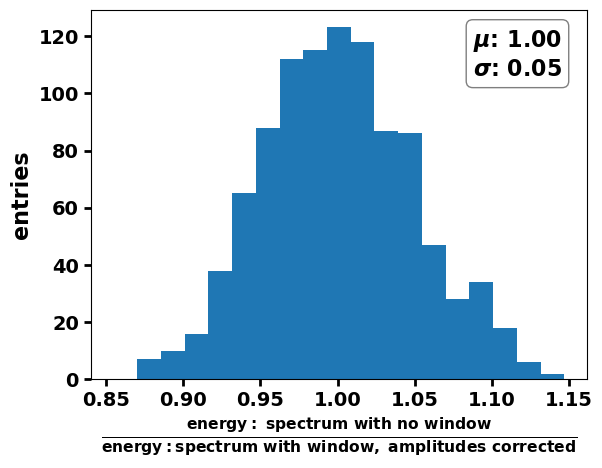

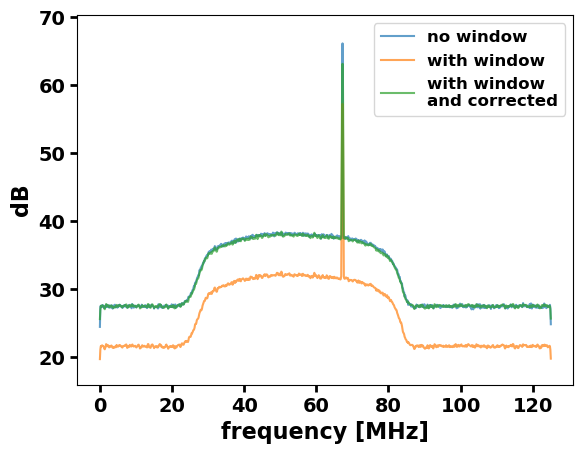

In [26]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

In [27]:
mock_traces_with_BB_DF = mock_traces_DF.copy(deep=True)
for i in range(mock_traces_with_BB_DF.index.size):
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace = mock_traces_with_BB_DF.iloc[i,2:].values
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    mock_traces_with_BB_DF.iloc[i,2:] = time_trace

In [28]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_with_BB_DF.iloc[:,2:].values)
diffs3 = diffs
label4final_histo.append('mock traces with BB pulse')

13.407272225566796
17.61897356794457


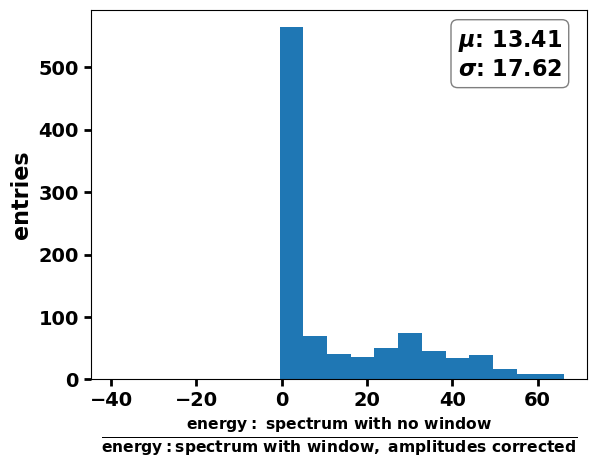

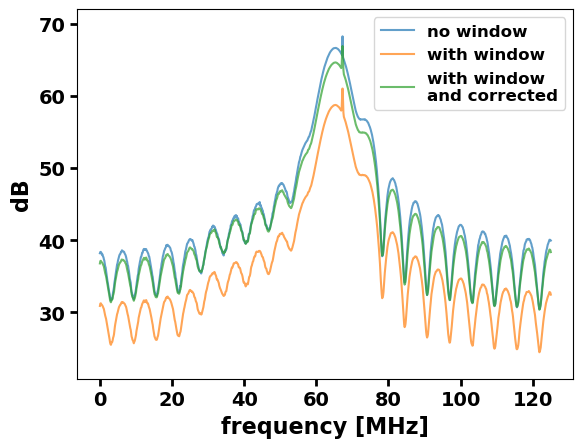

In [29]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

### Summary

simple traces
Mean and STD:-0.0005, 0.0610
Truncated Mean and STD: -0.0005, 0.0610
******
mock traces
Mean and STD:0.0009, 0.0487
Truncated Mean and STD: 0.0009, 0.0487
******
mock traces with BB pulse
Mean and STD:12.4073, 17.6190
Truncated Mean and STD: 12.4073, 17.6190
******


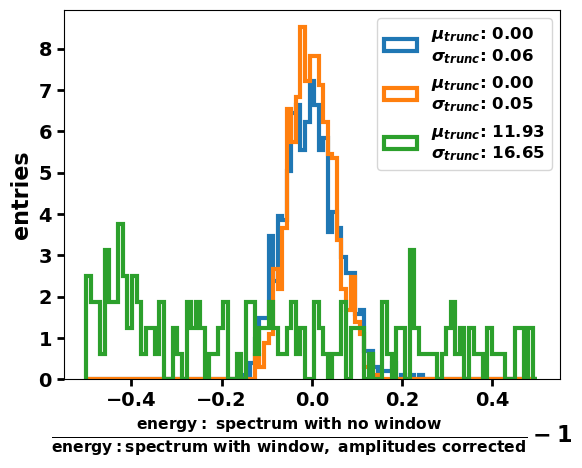

In [30]:
fig, ax = plt.subplots()
fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

diffs_list = np.asarray([diffs1, diffs2, diffs3], dtype="object") - 1
# diffs_list = [diffs1, diffs2]

bins = np.histogram_bin_edges(np.concatenate(diffs_list), bins=20)


# if bins == None:
bins = linspace_with_middle_value(
    np.mean(np.concatenate(diffs_list)), 2 * np.std(np.concatenate(diffs_list)), 20
)

bins = np.linspace(0.5, 1.5, 100) - 1

for i, diffs in enumerate(diffs_list):
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_diff_trun, std_diff_trun = calculate_truncated_stats(diffs, 1, 99)
    label = (
        text_box
    ) = f"$\mu_{{trunc}}$: {round(mean_diff_trun,2)+0:.2f}\n$\sigma_{{trunc}}$: {round(std_diff_trun,2)+0:.2f}"
    ax.hist(diffs, bins=bins, alpha=1, density=True, histtype="step", lw=3, label=label)
    # Calculate mean and standard deviation
    print(label4final_histo[i])
    print('Mean and STD:{:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print('Truncated Mean and STD: {:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print("******")

# ax.set_xlim(xax_min, xax_max)
ax.set_xlabel(
    r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}} -1$"
)
ax.set_ylabel("entries")
ax.legend()

In [31]:
print('The colors corespond to')
print(label4final_histo)
print(', respectively.')

The colors corespond to
['simple traces', 'mock traces', 'mock traces with BB pulse']
, respectively.


CONCLUSION: The broad band pulse in the trace spoils the energy recovery.